### 1. Import module and test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")

### 2. test Overview

* test Dictionary
    1. Survival : survival or not (0 : No, 1 : Yes)  
    2. pclass : Ticket class  
    3. sex : sex  
    4. Age : age in years  
    5. sibsp : # of sibilings / spouses aborad the titanic  
    6. parch : # of parents / children aborad the titanic  
    7. ticket : Ticket number  
    8. fare : Passenger fare  
    9. cabin : Cabin number  
    10. embarked : Port of Embarkation (C : Cherborug, Q : Queenstown, S : Southampton)  

**Train test**

각각 891개의 데이터가 있으며 12개의 column으로 이루어져 있음.

In [3]:
print(train.shape)

(891, 12)


Age에서 177개, Cabin에서 687개, Embarked에서 2개의 결측치가 있음.

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

각각의 데이터는 아래와 같이 이루어져 있음.

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


각 데이터의 분포는 아래와 같음.

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Test test**

Test test는 총 418개의 데이터로 이루어져있고 11개의 column으로 이루져있음

In [8]:
print(test.shape)

(418, 11)


Test 데이터는 Age에서 86개, Cabin에서 327개의 결측치가 있음.

In [9]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [10]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Test 데이터의 분포는 아래와 같음.

In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 3. Data Analyzation

Name column의 경우 Prefix를 정규표현식을 이용해 추출함.

In [12]:
train["Prefix"] = train["Name"].str.extract("([A-Za-z]+)\.")
test["Prefix"] = test["Name"].str.extract("([A-Za-z]+)\.")
train["Prefix"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Jonkheer      1
Ms            1
Sir           1
Capt          1
Countess      1
Don           1
Mme           1
Lady          1
Name: Prefix, dtype: int64

In [13]:
test["Prefix"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Prefix, dtype: int64

추출된 Prefix를 학습에 사용할 수 있도록 int화 시켜줍니다.

In [14]:
pre_dict = {"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Dr":4, "Rev":4, "Major":4, "Col":4, "Mlle":4, "Ms":4, "Countess":4, "Jonkheer":4, "Lady":4, "Capt":4, "Don":4, "Sir":4, "Mme":4, "Dona":4}
train["Prefix"] = train["Prefix"].map(pre_dict)
test["Prefix"] = test["Prefix"].map(pre_dict)

In [15]:
train["Prefix"].value_counts()

0    517
1    182
2    125
3     40
4     27
Name: Prefix, dtype: int64

In [16]:
test["Prefix"].value_counts()

0    240
1     78
2     72
3     21
4      7
Name: Prefix, dtype: int64

Embarked column의 결측치를 채워넣음. Embarked의 경우, 절대적 다수인 "S"로 채워줍니다. Test의 경우에는 Embarked Column에 결측치가 없으므로 Train 데이터에만 작업을 진행합니다.

In [17]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

Age의 경우, Prefix에 따라 Age 평균의 편차가 크므로, 각 Prefix의 평균치를 입력해줍니다.  
Test의 경우는 Train에서의 평균치를 삽입해줍니다.

<AxesSubplot:xlabel='Prefix', ylabel='Age'>

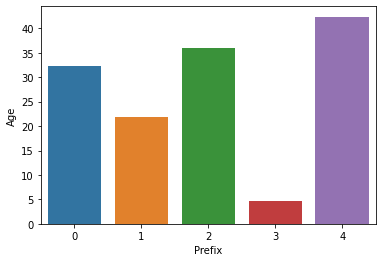

In [18]:
sb.barplot(x="Prefix", y="Age", ci=None, data= train)

In [19]:
train["Age"].fillna(train.groupby("Prefix")["Age"].transform("mean"), inplace=True)

# for test
for idx in range(len(test)):
    if np.isnan(test["Age"][idx]):
        test["Age"][idx] = train[train["Prefix"] == test["Prefix"][idx]]["Age"].mean()

Test에 있는 Fare의 평균치는 Train test Fare의 평균치를 넣어 결측치를 없애줍니다.

In [20]:
test["Fare"].fillna(32.204208, inplace=True)

현재 str 되어있는 Sex와 Embarked column또한 모델이 인식할 수 있도록 int화 시킴.

In [21]:
s_dict = {"male":0, "female":1}
train["Sex"] = train["Sex"].map(s_dict)
test["Sex"] = test["Sex"].map(s_dict)

In [22]:
ebk_dict = {"S": 0, "C": 1, "Q": 2}
train["Embarked"] = train["Embarked"].map(ebk_dict)
test["Embarked"] = test["Embarked"].map(ebk_dict)

이후 필요없는 label의 경우 drop을 시켜줍니다.

In [23]:
train.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)
test.drop(["Name", "Cabin", "Ticket"], axis=1, inplace=True)

Age와 Fare는 범위가 넓기때문에 4개의 범위로 grouping을 진행합니다.

In [24]:
train.loc[train["Age"] <=22.0, "Age"] = 0
train.loc[(train["Age"] >22.0) & (train["Age"] <= 28.0), "Age"] = 1
train.loc[(train["Age"] >28.0) & (train["Age"] <= 35.0), "Age"] = 2
train.loc[train["Age"] > 35.0, "Age"] = 3

train.loc[train["Fare"] <= 7.91, "Fare"] = 0
train.loc[(train["Fare"] > 7.91) & (train["Fare"] <= 14.4542), "Fare"] = 1
train.loc[(train["Fare"] > 14.4542) & (train["Fare"] <= 31), "Fare"] = 2
train.loc[train["Fare"] > 31, "Fare"] = 3
train["Age"] = train["Age"].astype("int64")
train["Fare"] = train["Fare"].astype("int64")


test.loc[test["Age"] <= 22.0, "Age"] = 0
test.loc[(test["Age"] > 22.0) & (test["Age"] <= 28.0), "Age"] = 1
test.loc[(test["Age"] > 28.0) & (test["Age"] <= 35.0), "Age"] = 2
test.loc[test["Age"] > 35, "Age"] = 3

test.loc[test["Fare"] <= 7.91, "Fare"] = 0
test.loc[(test["Fare"] > 7.91) & (test["Fare"] <= 14.4542), "Fare"] = 1
test.loc[(test["Fare"] > 14.4542) & (test["Fare"] <= 31), "Fare"] = 2
test.loc[test["Fare"] > 31, "Fare"] = 3

test["Age"] = test["Age"].astype("int64")
test["Fare"] = test["Fare"].astype("int64")

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int64
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int64
 7   Embarked  891 non-null    int64
 8   Prefix    891 non-null    int64
dtypes: int64(9)
memory usage: 62.8 KB


In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Pclass       418 non-null    int64
 2   Sex          418 non-null    int64
 3   Age          418 non-null    int64
 4   SibSp        418 non-null    int64
 5   Parch        418 non-null    int64
 6   Fare         418 non-null    int64
 7   Embarked     418 non-null    int64
 8   Prefix       418 non-null    int64
dtypes: int64(9)
memory usage: 29.5 KB


### 4. Train and Predict

In [27]:
# Classification module
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [28]:
y_train = train["Survived"]
x_train = train.drop('Survived', axis=1)

In [29]:
# Logistic Regression
logis = LogisticRegression()
logis.fit(x_train, y_train)
logis_score = logis.score(x_train, y_train)
print(f"Logistic regression Score: {logis_score}")

Logistic regression Score: 0.8148148148148148


In [30]:
# Support Vector Machine(SVM)
svm = SVC()
svm.fit(x_train, y_train)
svm_score = svm.score(x_train, y_train)
print(f"SVM score: {svm_score}")

SVM score: 0.835016835016835


In [31]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
knn_score = knn.score(x_train, y_train)
print(f"KNN score: {knn_score}")

KNN score: 0.8271604938271605


In [32]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
tree_score = tree.score(x_train, y_train)
print(f"Decision Tree Score: {tree_score}")

Decision Tree Score: 0.8866442199775533


In [33]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
forest_score = forest.score(x_train, y_train)
print(f"Random Forest score: {forest_score}")

Random Forest score: 0.8866442199775533


In [34]:
test_pred = test.copy()
test_pred = test_pred.drop("PassengerId", axis= 1)

In [35]:
y_pred = forest.predict(test_pred)
submission = pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived":y_pred})
submission.to_csv("submission.csv", index=False)

### 5. Train with K-Fold

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [38]:
print("---- Logistic Regression ----")
logis_k = LogisticRegression()
logis_k_score = cross_val_score(logis_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(logis_k_score)
print(f"Average logis_k score: {np.mean(logis_k_score)} \n")

print("---- Support Vector Machine ----")
svm_k = SVC()
svm_k_score = cross_val_score(svm_k, x_train, y_train, cv=kfold, n_jobs=1, scoring='accuracy')
print(svm_k_score)
print(f"Average svm_k score: {np.mean(svm_k_score)} \n")

print("---- K-Nerest Neighbor ----")
knn_k = KNeighborsClassifier(n_neighbors=5)
knn_k_score = cross_val_score(knn_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(knn_k_score)
print(f"Average knn_k score: {np.mean(knn_k_score)} \n")

print("---- Decision Tree ----")
tree_k = DecisionTreeClassifier()
tree_k_score = cross_val_score(tree_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(tree_k_score)
print(f"Average tree_k score: {np.mean(tree_k_score)} \n")

print("---- Random Forest ----")
forest_k = RandomForestClassifier()
forest_k_score = cross_val_score(forest_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(forest_k_score)
print(f"Average forest_k score: {np.mean(forest_k_score)} \n")

---- Logistic Regression ----
[0.77653631 0.80337079 0.84269663 0.7752809  0.84269663]
Average logis_k score: 0.8081162513338773 

---- Support Vector Machine ----
[0.81005587 0.82022472 0.87078652 0.79213483 0.83146067]
Average svm_k score: 0.8249325214989642 

---- K-Nerest Neighbor ----
[0.81005587 0.80898876 0.80337079 0.76966292 0.82022472]
Average knn_k score: 0.8024606113866046 

---- Decision Tree ----
[0.79329609 0.75842697 0.82022472 0.76404494 0.82022472]
Average tree_k score: 0.7912434875400163 

---- Random Forest ----
[0.79888268 0.79213483 0.80337079 0.78089888 0.80337079]
Average forest_k score: 0.7957315924926245 



In [39]:
svm_final = SVC()
svm_final.fit(x_train, y_train)
y_pred = svm_final.predict(test_pred)
submission = pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived":y_pred})
submission.to_csv("submission.csv", index=False)